# **Assignment 3 - Univariate Outlier Detection and Analysis**

By 23520011 - Sharaneshwar Punjal

1. Identify top 50 female heights in distributions generated in assignment 1, increase height of these female samples by 10 cm each 
2. Observe change in sample mean and sd after change in heights 
3. Run Classification algorithms developed in assignment 1.c on this altered dataset and note change in classification accuracy in each case 
4. Design strategies to detect outliers in female sample set 
    * Visual -
        1. plot the data histogram and obverse gaps, elbow etc 
        2. box and whisker plot. User of whiskers to find outliers 
    * Parametric -  
        1. convert heights into z score, 
        2. experiment with z score cutoffs such as 2 and 3 (on both sides) 
    * Non parametric 
        1. Detection and removal based on inter quartile range 
        2. Detection of outliers based on MAD 
        3. Experiment with cutoffs such as 1.5, 2, 3 etc (on both sides) 
5. Remove data labelled as outliers using z score or iqr or MAD cutoffs 
6. Run again the classification methods from assignment 1.c and document impact on mean, sd and classification accuracy 
7. Data trimming- drop lower and upper k% data(vary k between 1% to 15% in increments of 1%) from 1.a and run classification algorithms. Observe impact on accuracy via scatter plot

## 1. Generating the Dataset

Regeneration of the dataset as in Assignment 1:
- **Female heights:** 1000 samples from a Gaussian distribution with mean=152 cm and sd=5 cm.
- **Male heights:** 1000 samples from a Gaussian distribution with mean=166 cm and sd=5 cm.

We then combine these into a single DataFrame.

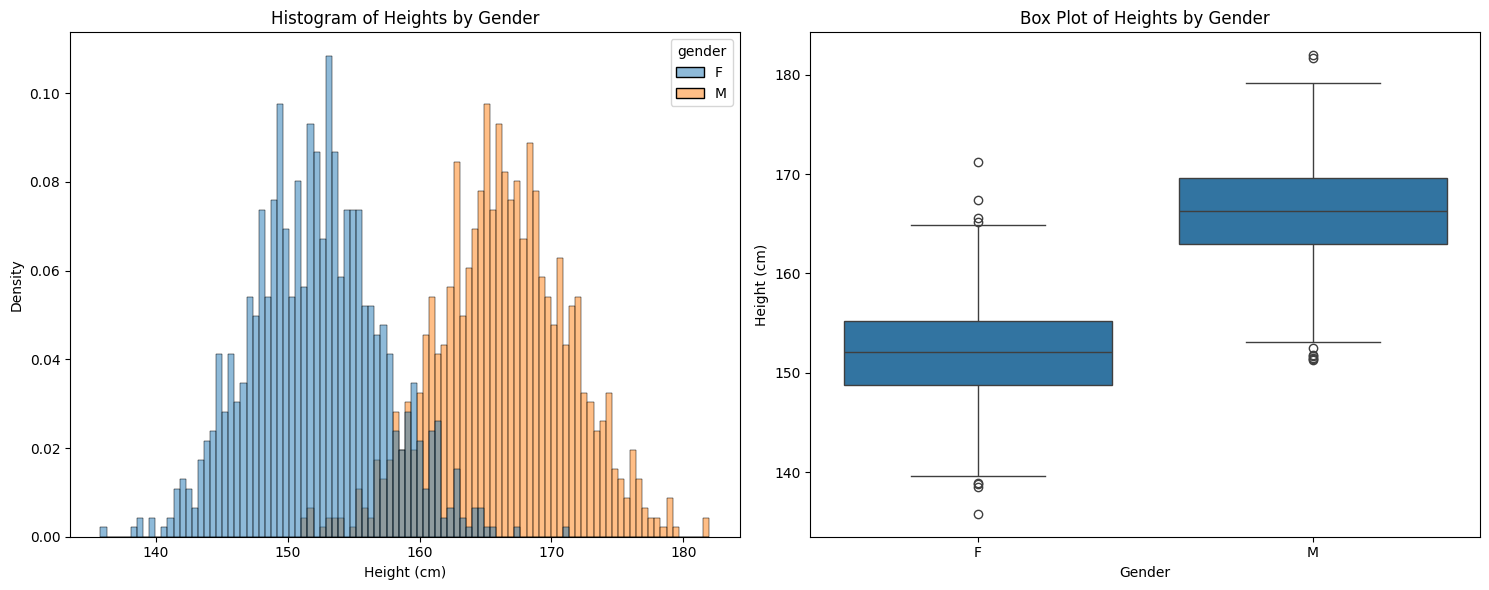

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# For reproducibility
np.random.seed(42)

# Parameters
n_samples = 1000
female_mean, male_mean = 152, 166
sd = 5

# Generate samples
female_heights = np.random.normal(loc=female_mean, scale=sd, size=n_samples)
male_heights = np.random.normal(loc=male_mean, scale=sd, size=n_samples)

# Create DataFrames with labels
df_female = pd.DataFrame({'height': female_heights, 'gender': 'F'})
df_male = pd.DataFrame({'height': male_heights, 'gender': 'M'})

# Combine into one dataset
df = pd.concat([df_female, df_male], ignore_index=True)

# Plotting histogram and box plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(data=df, x="height", hue="gender", bins=100, stat="density", common_norm=False, ax=axes[0])
axes[0].set_title("Histogram of Heights by Gender")
axes[0].set_xlabel("Height (cm)")
axes[0].set_ylabel("Density")

sns.boxplot(data=df, x="gender", y="height", ax=axes[1])
axes[1].set_title("Box Plot of Heights by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Height (cm)")

plt.tight_layout()
plt.show()

## 2. Introducing Outliers into the Female Sample

Identify the top 50 female height values (the highest ones) and increase each by 10 cm.

In [ ]:
# Sort the female data by height in descending order and select the top 50 indices
female_data_sorted = df_female.sort_values(by='height', ascending=False)
top_50_indices = female_data_sorted.head(50).index

# Create a new (altered) dataset by copying the original
df_altered = df.copy()

# Increase the top 50 female height values by 10 cm each
df_altered.loc[top_50_indices, 'height'] += 10

# Plotting histogram and box plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(data=df_altered, x="height", hue="gender", bins=100, stat="density", common_norm=False, ax=axes[0])
axes[0].set_title("Histogram of Altered Heights by Gender")
axes[0].set_xlabel("Height (cm)")
axes[0].set_ylabel("Density")

sns.boxplot(data=df_altered, x="gender", y="height", ax=axes[1])
axes[1].set_title("Box Plot of Altered Heights by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Height (cm)")

plt.tight_layout()
plt.show()

### We now compute statistics for the female heights before and after the alteration.

In [37]:
# Statistics for female heights before alteration
orig_female_stats = df[df['gender'] == 'F']['height'].describe()

# Statistics for female heights after alteration
altered_female_stats = df_altered[df_altered['gender'] == 'F']['height'].describe()

print("Original Female Height Statistics:")
print(orig_female_stats)
print("\nAltered Female Height Statistics (after adding 10 cm to top 50):")
print(altered_female_stats)

Original Female Height Statistics:
count    1000.000000
mean      152.096660
std         4.896080
min       135.793663
25%       148.762048
50%       152.126503
75%       155.239719
max       171.263657
Name: height, dtype: float64

Altered Female Height Statistics (after adding 10 cm to top 50):
count    1000.000000
mean      152.596660
std         6.256017
min       135.793663
25%       148.762048
50%       152.126503
75%       155.239719
max       181.263657
Name: height, dtype: float64


**Observations:**
- The mean of the female heights has increased.
- The standard deviation has also increased due to the addition of outliers.
- Female Histogram will have a long tail on the right side.

## 3. Classification on the Altered Dataset

* Likelihood‐based Classification
* Threshold‐based Classification
* Quantization‐based Classification

In [38]:
def gaussian_pdf(x, mean, sd):
    return (1/(sd * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mean)/sd)**2)

# --- 1. Likelihood‐based Classifier ---
def likelihood_classifier(df_input, gender_col='gender', height_col='height'):
    params = df_input.groupby(gender_col)[height_col].agg(['mean', 'std']).to_dict('index')
    predictions = []
    for h in df_input[height_col]:
        likelihood_F = gaussian_pdf(h, params['F']['mean'], params['F']['std'])
        likelihood_M = gaussian_pdf(h, params['M']['mean'], params['M']['std'])
        predictions.append('F' if likelihood_F > likelihood_M else 'M')
    return predictions

# --- 2. Threshold‐based Classifier ---
def threshold_classifier(df_input, gender_col='gender', height_col='height'):
    mean_F = df_input[df_input[gender_col]=='F'][height_col].mean()
    mean_M = df_input[df_input[gender_col]=='M'][height_col].mean()
    threshold = (mean_F + mean_M) / 2
    predictions = df_input[height_col].apply(lambda x: 'F' if x < threshold else 'M')
    return predictions, threshold

# --- 3. Quantization‐based Classifier ---
def quantization_classifier(df_input, bin_width=0.5, gender_col='gender', height_col='height'):
    min_height = df_input[height_col].min()
    max_height = df_input[height_col].max()
    bins = np.arange(min_height, max_height + bin_width, bin_width)
    
    df_temp = df_input.copy()
    df_temp['bin'] = pd.cut(df_temp[height_col], bins=bins, include_lowest=True)
    
    bin_majority = df_temp.groupby('bin', observed=False)[gender_col].agg(
        lambda x: x.value_counts().idxmax() if not x.empty else None
    )
    
    predictions = df_temp['bin'].map(bin_majority).fillna('M')
    return predictions

### Run Classification Methods on the Altered Dataset

In [39]:
# Apply classifiers on the altered dataset
res_likelihood = likelihood_classifier(df_altered)
res_threshold, threshold_value = threshold_classifier(df_altered)
res_quantization = quantization_classifier(df_altered)

# Compute confusion matrices and accuracies
true_labels = df_altered['gender']

cm_likelihood = confusion_matrix(true_labels, res_likelihood, labels=['F','M'])
acc_likelihood = accuracy_score(true_labels, res_likelihood)

cm_threshold = confusion_matrix(true_labels, res_threshold, labels=['F','M'])
acc_threshold = accuracy_score(true_labels, res_threshold)

cm_quantization = confusion_matrix(true_labels, res_quantization, labels=['F','M'])
acc_quantization = accuracy_score(true_labels, res_quantization)

print("Likelihood-based Classifier")
print("Confusion Matrix:\n", cm_likelihood)
print("Accuracy: {:.2f}".format(acc_likelihood))

print("\nThreshold-based Classifier (Threshold = {:.2f})".format(threshold_value))
print("Confusion Matrix:\n", cm_threshold)
print("Accuracy: {:.2f}".format(acc_threshold))

print("\nQuantization-based Classifier")
print("Confusion Matrix:\n", cm_quantization)
print("Accuracy: {:.2f}".format(acc_quantization))

Likelihood-based Classifier
Confusion Matrix:
 [[934  66]
 [ 89 911]]
Accuracy: 0.92

Threshold-based Classifier (Threshold = 159.48)
Confusion Matrix:
 [[924  76]
 [ 85 915]]
Accuracy: 0.92

Quantization-based Classifier
Confusion Matrix:
 [[910  90]
 [ 60 940]]
Accuracy: 0.93


### Observations
- Likelihood - Because of the outliers, our estimated mean and sd for female heights are higher and wider than they should be. The computed likelihood, or probability, for a typical female height then drops unexpectedly. In short, the model's understanding of what's normal for females gets skewed by the extreme values.
- Threshold - The decision threshold is calculated as the midpoint between the male and female means, so when outliers push the female mean up, the threshold also shifts higher. This shift can cause some original female samples to be misclassified as male. Essentially, the boundary that separates the two groups no longer accurately reflects the true distributions.
- Quantization - This method takes the data and bins it, assigning the most common gender in each bin as the prediction. However, when a bin fills up with too many outlier values, its local majority may become misleading. This is essentially how sensitive this approach will be depending on how many of the samples fall into each bin that have been affected by outliers.

## 4. Outlier Detection Strategies for the Female Sample

### **Visual Methods**

We start by plotting:
- A histogram to observe the distribution.
- A boxplot to see the spread and identify extreme values.

_Observation:_ Gaps or extreme values in the boxplot indicate the outliers.

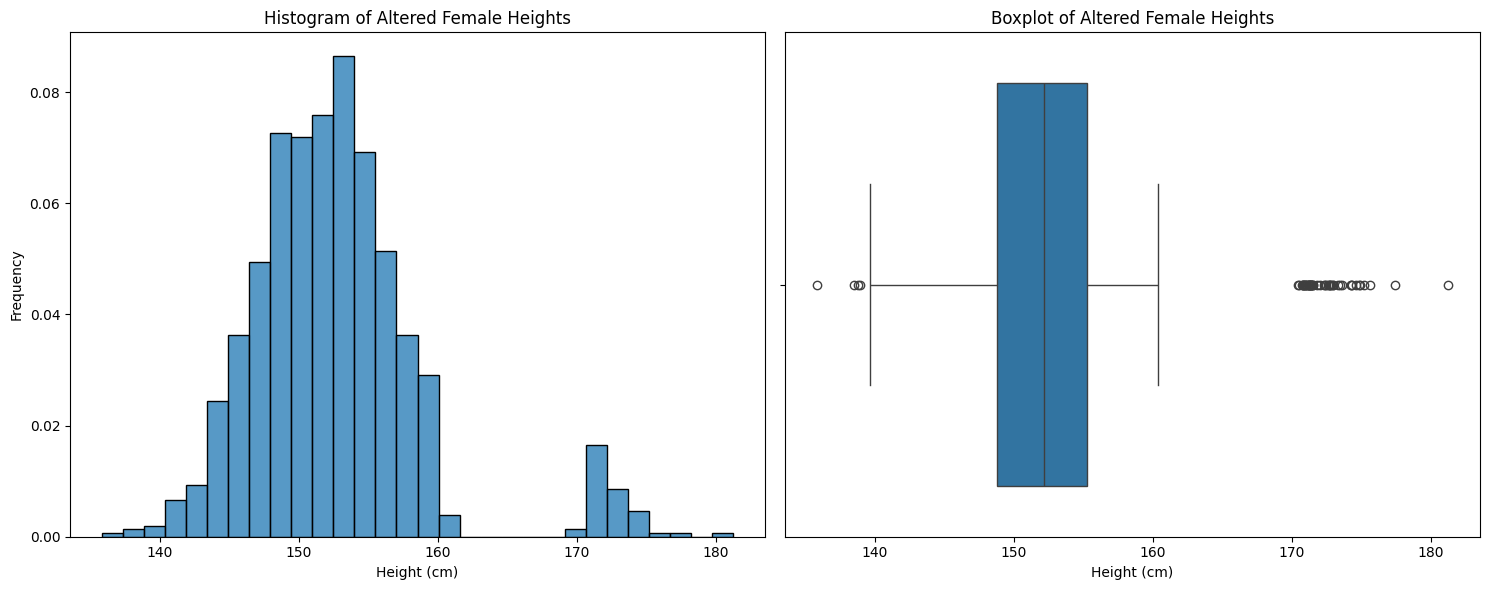

In [42]:
# Plotting histogram and box plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_altered[df_altered['gender']=='F']['height'], bins=30, stat="density", common_norm=False, ax=axes[0])
axes[0].set_title("Histogram of Altered Female Heights")
axes[0].set_xlabel("Height (cm)")
axes[0].set_ylabel("Frequency")

sns.boxplot(x=df_altered[df_altered['gender']=='F']['height'], ax=axes[1])
axes[1].set_title("Boxplot of Altered Female Heights")
axes[1].set_xlabel("Height (cm)")

plt.tight_layout()
plt.show()

### **Parametric Method: Z-Score Based Detection**

We convert the female heights into z-scores and identify outliers using two cutoffs of 2 and 3 standard deviations from the mean.

_Observation:_ There are many outliers detected which have z-scores greater than 2 or 3.

In [43]:
# Extract altered female heights
female_altered = df_altered[df_altered['gender']=='F']['height']

# Compute mean and std for the altered female sample
female_mean_altered = female_altered.mean()
female_std_altered = female_altered.std()

# Compute z-scores
z_scores = (female_altered - female_mean_altered) / female_std_altered

# Identify outliers using cutoffs
outliers_z2 = female_altered[np.abs(z_scores) > 2]
outliers_z3 = female_altered[np.abs(z_scores) > 3]

print("Number of outliers with z > 2:", len(outliers_z2))
print("Number of outliers with z > 3:", len(outliers_z3))

Number of outliers with z > 2: 56
Number of outliers with z > 3: 32


### **Non-Parametric Methods**

**i. Interquartile Range (IQR) Method**

We compute Q1, Q3 and IQR, and then define outliers as those samples lying outside:

- Lower bound: Q1 - 1.5 * IQR  
- Upper bound: Q3 + 1.5 * IQR

**ii. Median Absolute Deviation (MAD) Method**

We compute the median absolute deviation and then use a modified z‐score to flag outliers. Here, we demonstrate using a cutoff factor (e.g., 3).

In [ ]:
# IQR Method for altered female heights
Q1 = female_altered.quantile(0.25)
Q3 = female_altered.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = female_altered[(female_altered < lower_bound) | (female_altered > upper_bound)]
print("Number of outliers detected by IQR method:", len(outliers_iqr))

# MAD Method for altered female heights
median_female = female_altered.median()
MAD = np.median(np.abs(female_altered - median_female))

# Compute modified z-scores
# 0.6745 is the constant, MAD is approximately 0.6745 * std
modified_z_score = 0.6745 * (female_altered - median_female) / MAD
cutoff = 3
outliers_mad = female_altered[np.abs(modified_z_score) > cutoff]
print("Number of outliers detected by MAD method (cutoff {}):".format(cutoff), len(outliers_mad))

Number of outliers detected by IQR method: 54
Number of outliers detected by MAD method (cutoff 3): 51


## 5. Removing Outliers and Re-running Classification

Now we remove the female outliers detected by the IQR method.

- Remove these outlier samples from the altered dataset.
- Re‐compute the female sample statistics.
- Run the three classification methods again on the cleaned dataset.
- Compare the new confusion matrices and accuracies to those from the altered dataset.

In [45]:
# Remove outliers from female samples (using IQR bounds)
df_cleaned = df_altered.copy()

# Boolean mask for female rows
female_mask = df_cleaned['gender'] == 'F'

# Remove lower and upper outliers for females using .loc[]
df_cleaned = df_cleaned.loc[~((female_mask) & (df_cleaned['height'] < lower_bound))]
df_cleaned = df_cleaned.loc[~((female_mask) & (df_cleaned['height'] > upper_bound))]

print("Shape before cleaning:", df_altered.shape)
print("Shape after cleaning:", df_cleaned.shape)
print("Number of outliers removed:", df_altered.shape[0] - df_cleaned.shape[0])

Shape before cleaning: (2000, 2)
Shape after cleaning: (1946, 2)
Number of outliers removed: 54


### **Female Sample Statistics After Outlier Removal**

_Observations:_
- The mean height of female samples decreases after removing outliers, as extreme high values are no longer pulling the average up.
- The standard deviation also decreases (even lower than original), as the spread of the data is now more concentrated around the mean.

In [47]:
print("Original female height statistics:")
print(df[df['gender'] == 'F']['height'].describe())

print("\nFemale height statistics after outlier removal:")
print(df_cleaned[df_cleaned['gender'] == 'F']['height'].describe())

Original female height statistics:
count    1000.000000
mean      152.096660
std         4.896080
min       135.793663
25%       148.762048
50%       152.126503
75%       155.239719
max       171.263657
Name: height, dtype: float64

Female height statistics after outlier removal:
count    946.000000
mean     151.606577
std        4.279973
min      139.641777
25%      148.614491
50%      151.830470
75%      154.812115
max      160.382187
Name: height, dtype: float64


### **Run Classification on the Cleaned Dataset**

In [48]:
# Apply classifiers on the cleaned dataset
res_likelihood_cleaned = likelihood_classifier(df_cleaned)
res_threshold_cleaned, threshold_value_cleaned = threshold_classifier(df_cleaned)
res_quantization_cleaned = quantization_classifier(df_cleaned)

# Compute confusion matrices and accuracies for the cleaned dataset
true_labels_cleaned = df_cleaned['gender']

cm_likelihood_cleaned = confusion_matrix(true_labels_cleaned, res_likelihood_cleaned, labels=['F','M'])
acc_likelihood_cleaned = accuracy_score(true_labels_cleaned, res_likelihood_cleaned)

cm_threshold_cleaned = confusion_matrix(true_labels_cleaned, res_threshold_cleaned, labels=['F','M'])
acc_threshold_cleaned = accuracy_score(true_labels_cleaned, res_threshold_cleaned)

cm_quantization_cleaned = confusion_matrix(true_labels_cleaned, res_quantization_cleaned, labels=['F','M'])
acc_quantization_cleaned = accuracy_score(true_labels_cleaned, res_quantization_cleaned)

print("Likelihood-based Classifier (After Outlier Removal)")
print("Confusion Matrix:\n", cm_likelihood_cleaned)
print("Accuracy: {:.2f}".format(acc_likelihood_cleaned))

print("\nThreshold-based Classifier (Threshold = {:.2f}) (After Outlier Removal)".format(threshold_value_cleaned))
print("Confusion Matrix:\n", cm_threshold_cleaned)
print("Accuracy: {:.2f}".format(acc_threshold_cleaned))

print("\nQuantization-based Classifier (After Outlier Removal)")
print("Confusion Matrix:\n", cm_quantization_cleaned)
print("Accuracy: {:.2f}".format(acc_quantization_cleaned))

Likelihood-based Classifier (After Outlier Removal)
Confusion Matrix:
 [[897  49]
 [ 63 937]]
Accuracy: 0.94

Threshold-based Classifier (Threshold = 158.98) (After Outlier Removal)
Confusion Matrix:
 [[905  41]
 [ 71 929]]
Accuracy: 0.94

Quantization-based Classifier (After Outlier Removal)
Confusion Matrix:
 [[905  41]
 [ 64 936]]
Accuracy: 0.95


### **Observations**
- With the removal of extreme female heights, the **Likelihood-Based Method** appears to provide more credible probability estimates. Previously, the outliers had skewed the likelihood calculations, which in some cases made accurate classification of females more challenging. A cleaner data set means better and more accurate probabilities and thus improved balance in the overall classification.

- In the **Threshold-Based Method**, the decision boundary is refined by the elimination of outliers, reducing misclassification. Earlier on, extreme female heights skewed the threshold, causing the model to be prone to errors. Now that outliers are removed, the threshold is more stable, allowing for a better definition between male and female samples.

- The removal of outliers allows local majority votes to carry more weight in the **Quantization-Based Method**. Earlier, extreme values in some bins would have great distortions on predictions, thereby diminishing the reliability of the method. However, with cleaner datasets, bin-based classification starts becoming more stable, although success still depends on the number of altered samples that still existed in those bins to begin with. 

## 6. Data Trimming - Alternative Approach to Outlier Detection

**Task:**
- Drop the lower and upper *k*% of the data (where *k* varies from 1% to 15% in increments of 1%) from the original dataset.
- Run the three classification methods on each trimmed dataset.
- Record and plot the classification accuracy and trimming percentage.

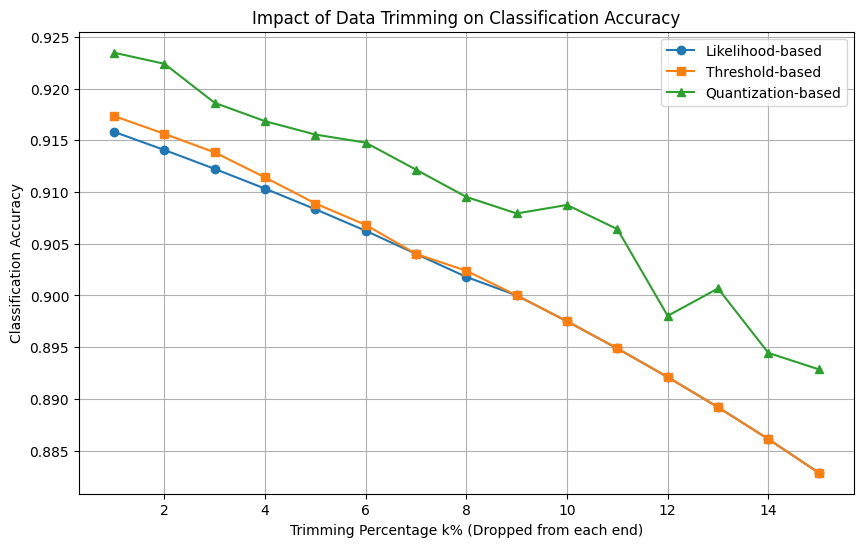

In [49]:
# Define the range of trimming percentages
k_values = np.arange(1, 16)
accuracy_likelihood = []
accuracy_threshold = []
accuracy_quantization = []

# Sort the overall dataset by height for trimming
df_sorted = df.sort_values(by='height').reset_index(drop=True)
n_total = len(df_sorted)

for k in k_values:
    k_lower = int(n_total * k/100)
    k_upper = int(n_total * (1 - k/100))
    df_trimmed = df_sorted.iloc[k_lower:k_upper].copy()
    
    # Apply classifiers on the trimmed dataset
    res_likelihood_trim = likelihood_classifier(df_trimmed)
    res_threshold_trim, _ = threshold_classifier(df_trimmed)
    res_quantization_trim = quantization_classifier(df_trimmed)
    
    true_labels_trim = df_trimmed['gender']
    
    accuracy_likelihood.append(accuracy_score(true_labels_trim, res_likelihood_trim))
    accuracy_threshold.append(accuracy_score(true_labels_trim, res_threshold_trim))
    accuracy_quantization.append(accuracy_score(true_labels_trim, res_quantization_trim))

# Plot the impact of trimming on classification accuracy
plt.figure(figsize=(10,6))
plt.plot(k_values, accuracy_likelihood, marker='o', label='Likelihood-based')
plt.plot(k_values, accuracy_threshold, marker='s', label='Threshold-based')
plt.plot(k_values, accuracy_quantization, marker='^', label='Quantization-based')
plt.xlabel("Trimming Percentage k% (Dropped from each end)")
plt.ylabel("Classification Accuracy")
plt.title("Impact of Data Trimming on Classification Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**Observations:**
- As the trimming percentage increases, the overall sample size decreases.
- Depending on how the extreme values affect the classifier, moderate trimming might improve accuracy by removing noise, whereas excessive trimming may hurt performance by discarding too much data.
- Likelihood-Based Classifier - Accuracy decreases steadily as trimming percentage increases. This is because removing extreme values reduces the data available to estimate statistical parameters, leading to less precise likelihood calculations.

- Threshold-Based Classifier - The accuracy decline is more pronounced here, as the classifier becomes less effective at identifying thresholds with reduced data. This suggests that thresholds are highly sensitive to the amount of available information.
- Quantization-Based Classifier - Although it starts with higher accuracy than the other methods, it shows fluctuations as the trimming increases. This is likely due to bins becoming sparse or empty, making the majority voting mechanism unreliable.